# Model interpretations using PDP and SHAP

In [1]:
#Import neccessary libraries
import numpy as np
import pandas as pd
from sklearn import datasets
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import math
from sklearn import preprocessing
from collections import defaultdict
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit,StratifiedKFold
from sklearn.metrics import roc_curve,auc,roc_auc_score,make_scorer,classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, DMatrix, plot_importance
import pickle
import shap
from pdpbox import pdp,info_plots,get_dataset
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """
        Imputation functions
        """
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)


# Make all necessary changes here (mandatory)

In [2]:
# https://www.kaggle.com/shrutimechlearn/churn-modelling#Churn_Modelling.csv
# This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.

#Load the dataset:
path_to_dataset='/Users/XXXXXX/Downloads/Churn_Modelling.csv'
#Identify Target Variable
target_variable='Exited'
#Columns to be ignored
colums_to_ignore=['RowNumber','CustomerId','Surname']
#2 way interactions for (Pick 2 variables in the dataset)
interactions_2way=['Age', 'CreditScore']

# Modify below as required (else will run with default settings)

Text(0,0.5,'Feature Importance Score')

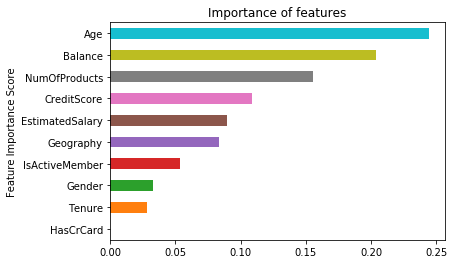

In [3]:
#Dataset with required features
df=pd.read_csv(path_to_dataset)
final_cols_to_be_used=list(set(df.columns)-set(colums_to_ignore))
df=df[final_cols_to_be_used]

#Label Encoding
df = DataFrameImputer().fit_transform(df)
d=defaultdict(preprocessing.LabelEncoder)
fit=df.select_dtypes(include=['object']).apply(lambda x: d[x.name].fit_transform(x))

for i in list(d.keys()):
    df[i]=d[i].transform(df[i])

#Store the mappings    
mappings_list=[]
for i in list(d.keys()):
    mappings='mapping'+str(i)
    mappings_list.append(mappings)

for i in range(0,len(mappings_list)):
    mappings_list[i]=dict(zip(list(d.values())[i].classes_, list(d.values())[i].transform(list(d.values())[i].classes_)))
    

# Splitting the datasets and modeling   
X=df.drop(target_variable,axis=1)
Y=df[target_variable]
x_train_and_cv,x_test,y_train_and_cv,y_test=train_test_split(X,Y,test_size=0.1,random_state=2020,stratify=Y)
x_train,x_cv,y_train,y_cv=train_test_split(x_train_and_cv,y_train_and_cv,test_size=0.1,random_state=2020,stratify=y_train_and_cv)
_feat=x_train.columns.tolist()
baseline=GradientBoostingClassifier()
baseline.fit(x_train[_feat],y_train)
predictors=list(x_train)
feat_imp=pd.Series(baseline.feature_importances_,predictors).sort_values(ascending=True)
feat_imp.plot(kind='barh',title='Importance of features')
plt.ylabel('Feature Importance Score')

In [4]:
#Stats
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(x_cv[_feat],y_cv)))
pred=baseline.predict(x_cv)
print(classification_report(y_cv,pred))

Accuracy of the GBM on test set: 0.864
             precision    recall  f1-score   support

          0       0.88      0.97      0.92       717
          1       0.77      0.47      0.59       183

avg / total       0.86      0.86      0.85       900



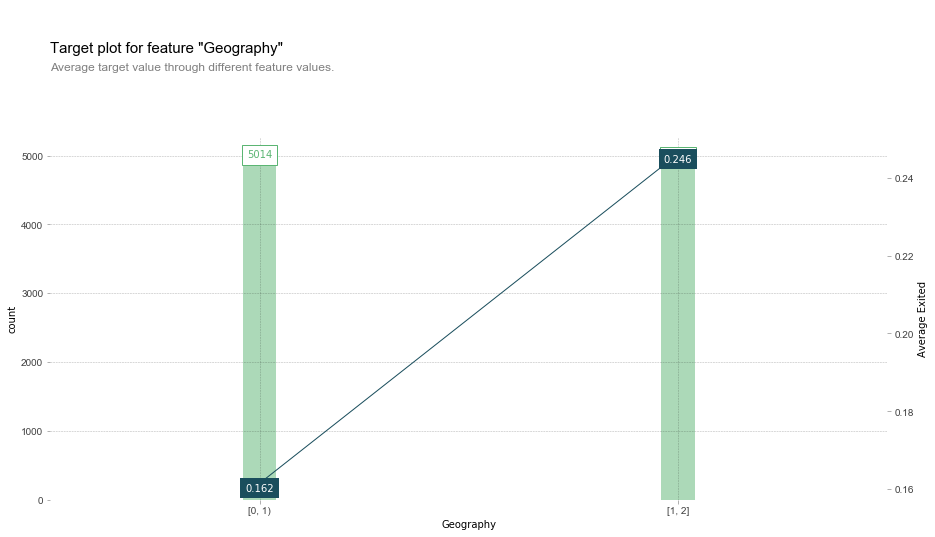

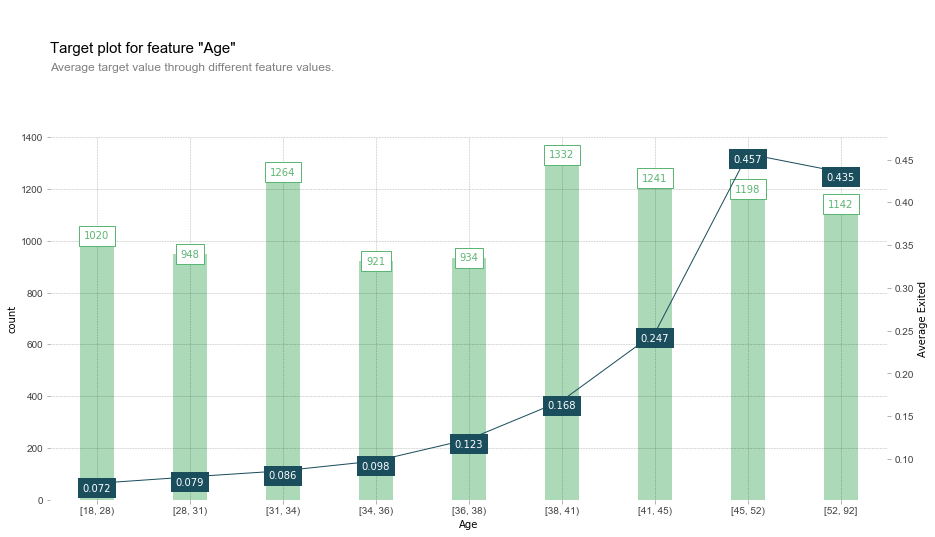

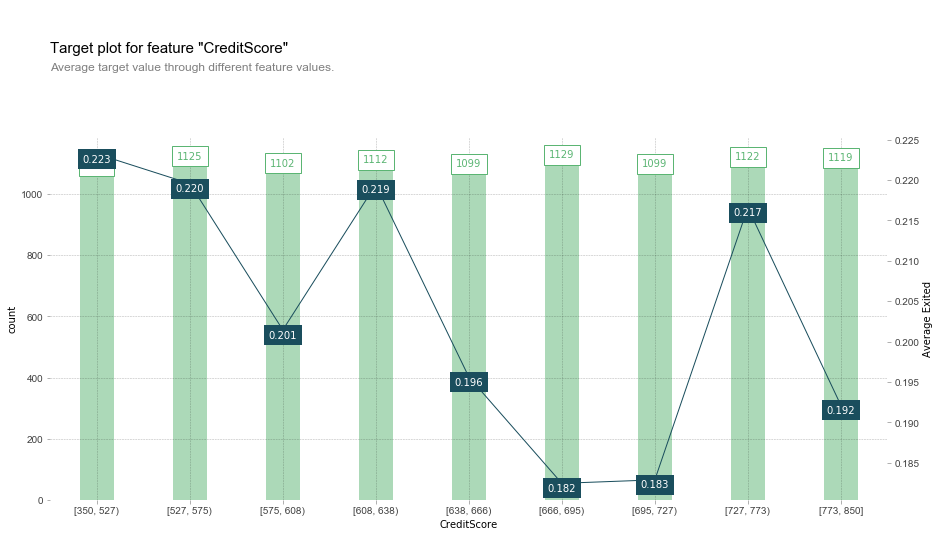

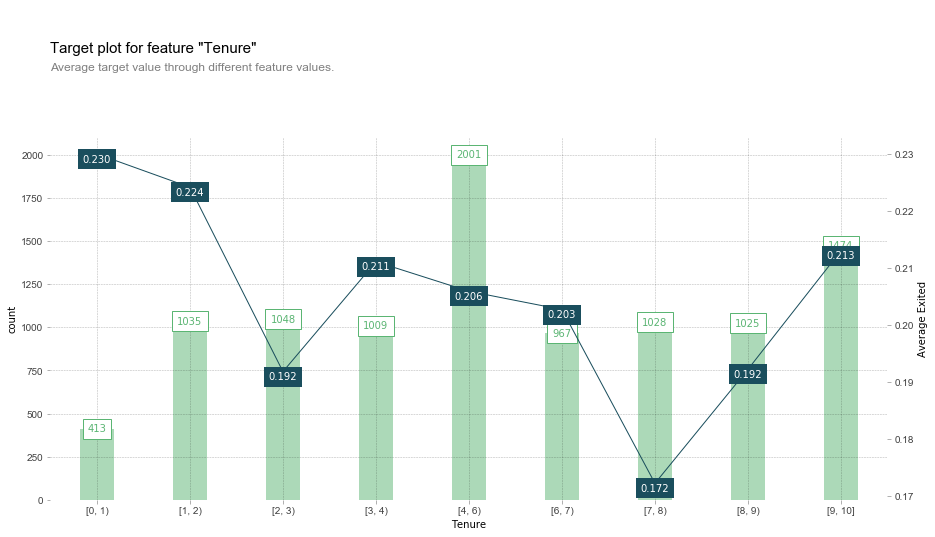

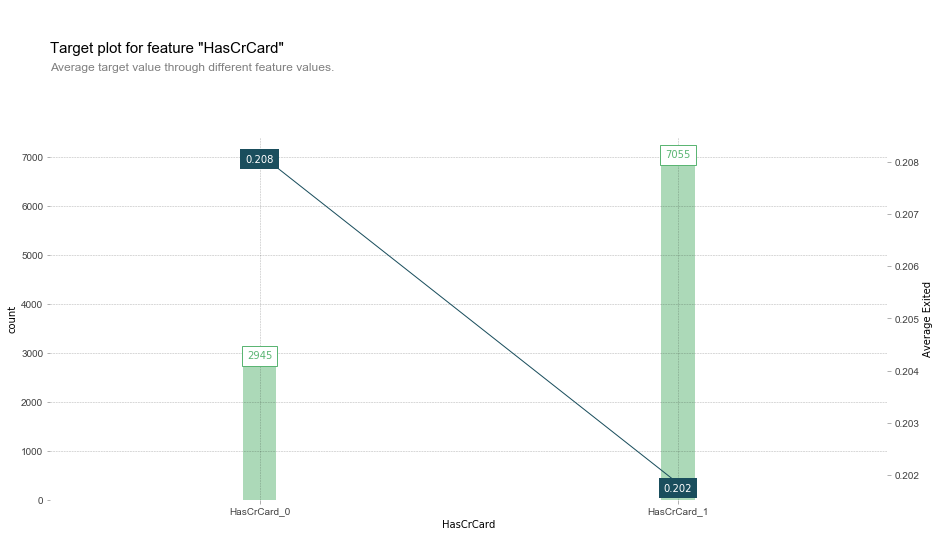

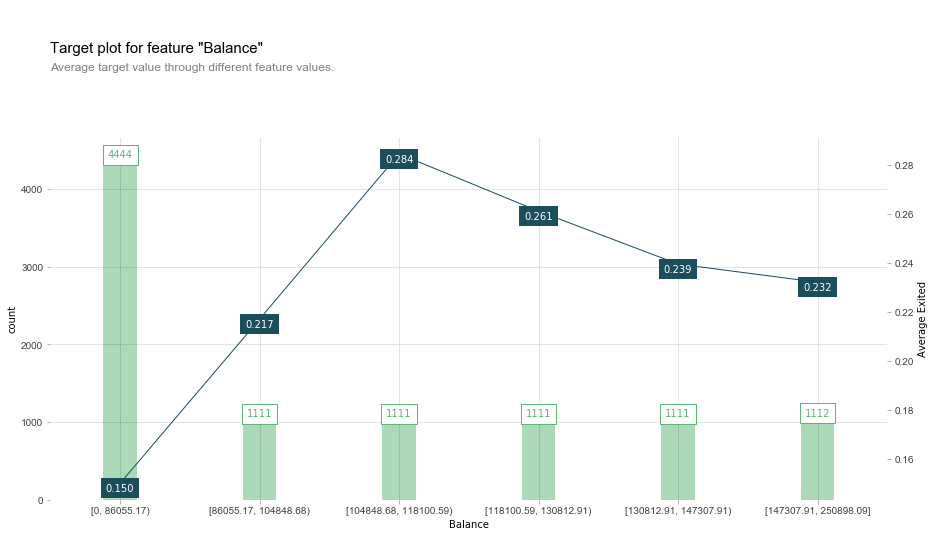

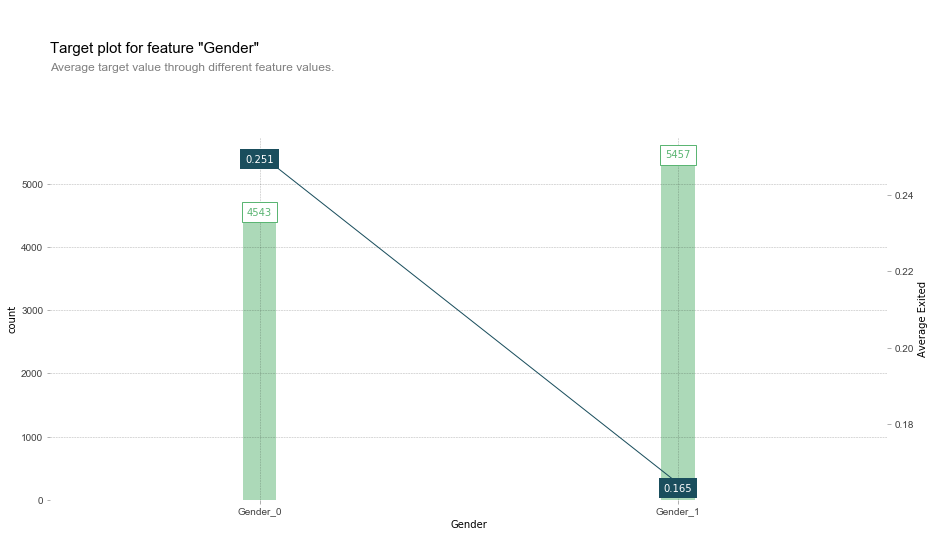

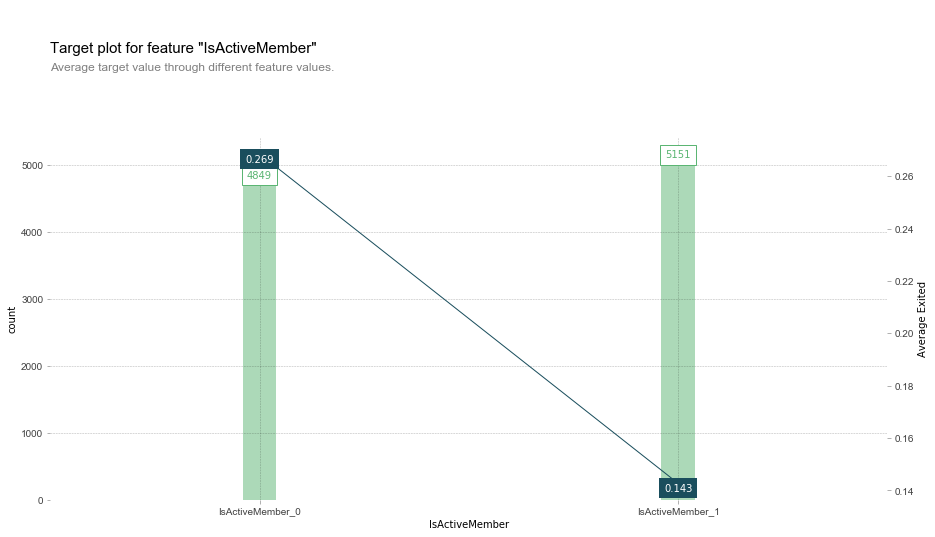

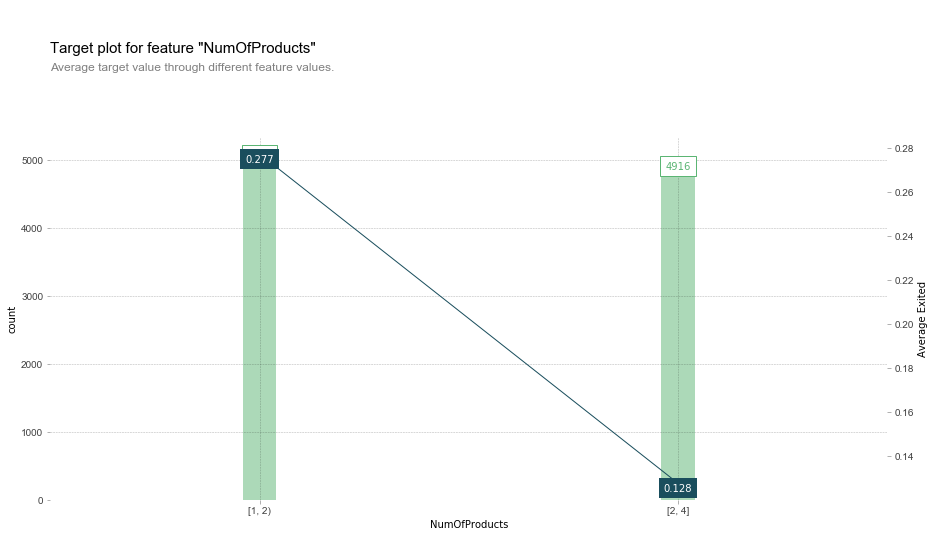

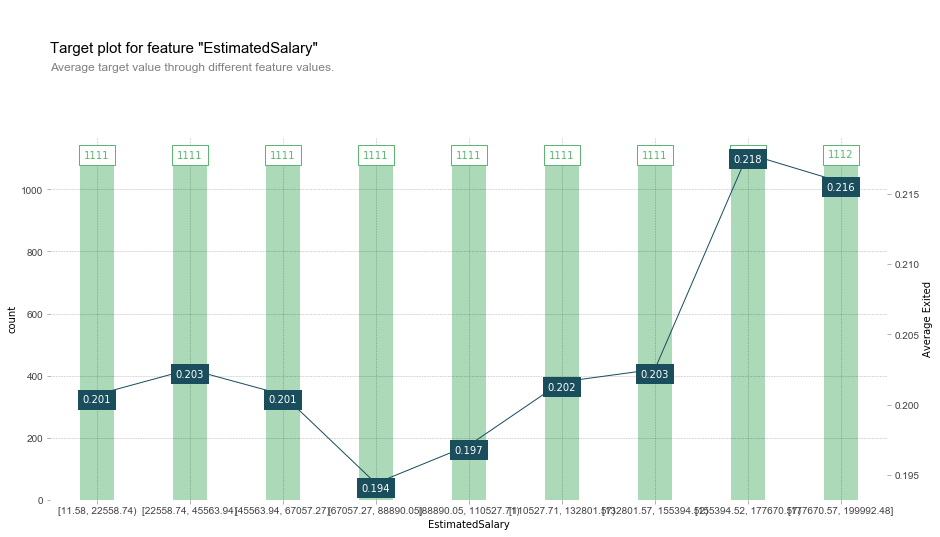

In [5]:
#Target Plots
for _ in X.columns.tolist():
    fig,axes,summary_df=info_plots.target_plot(
    df=df,
    feature=_,
    feature_name=_,
    target=target_variable
    )


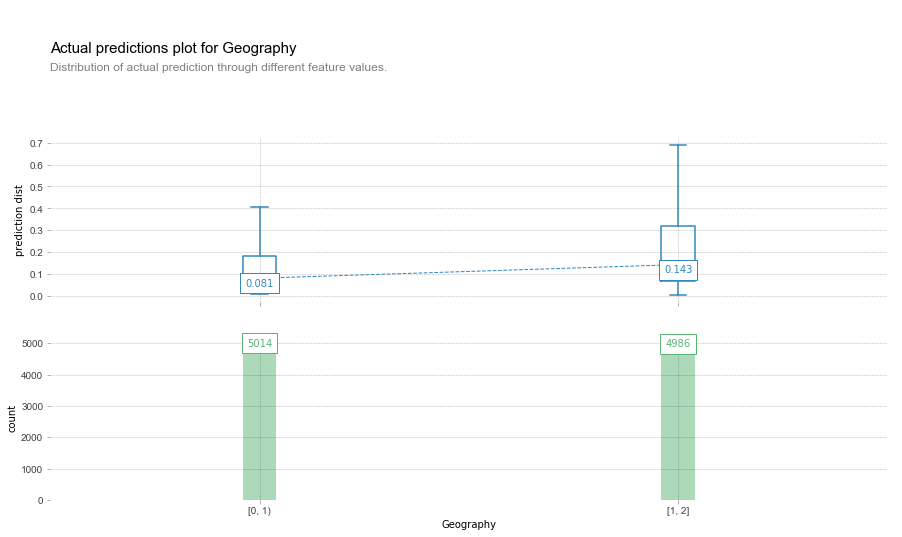

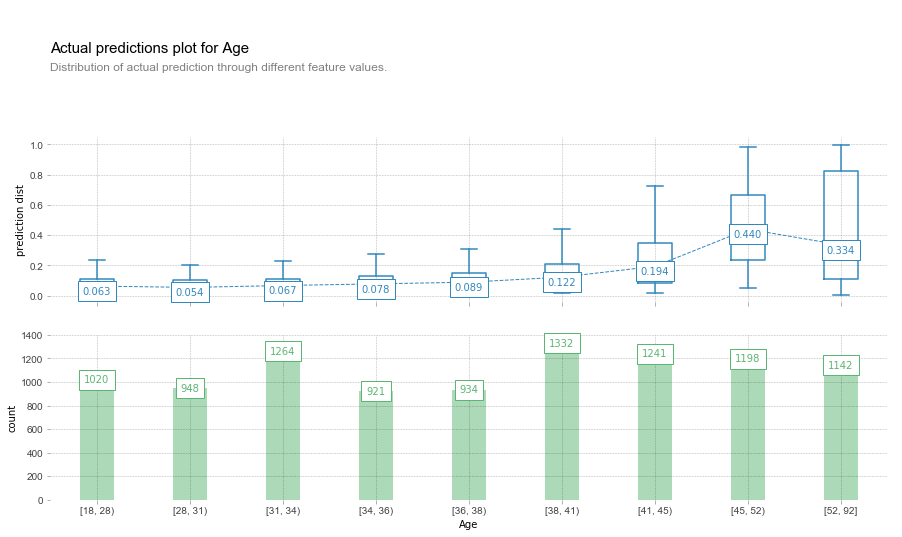

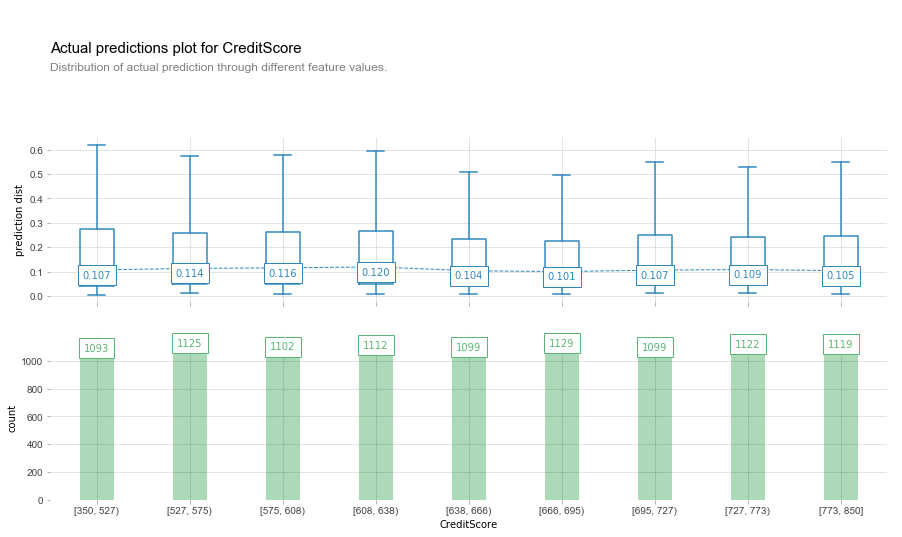

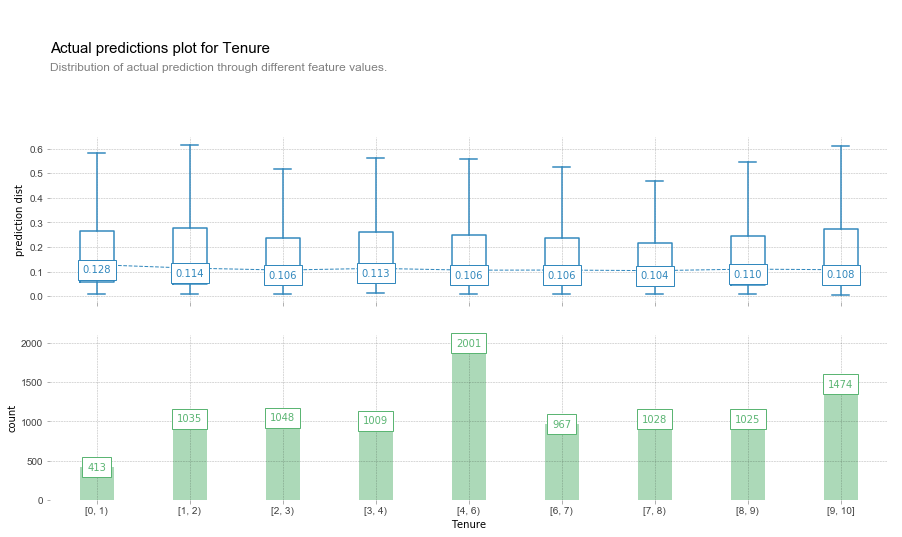

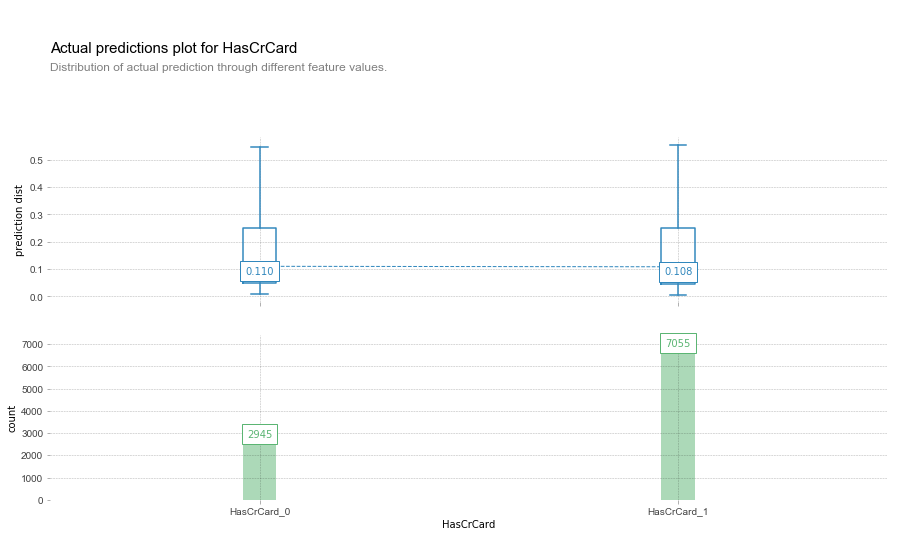

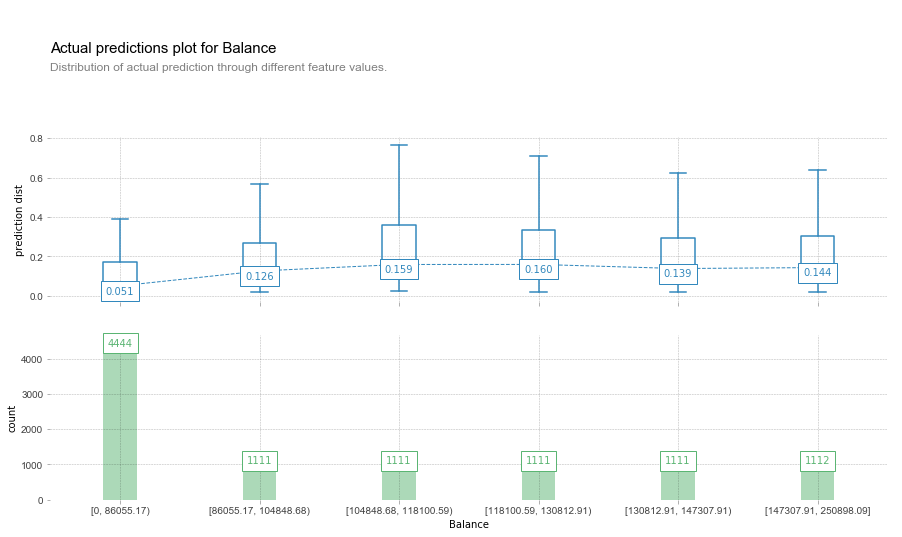

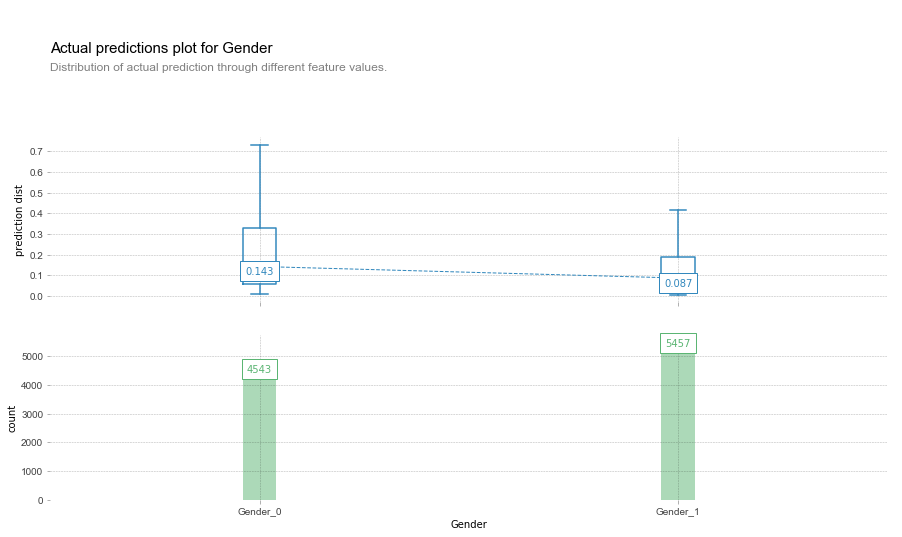

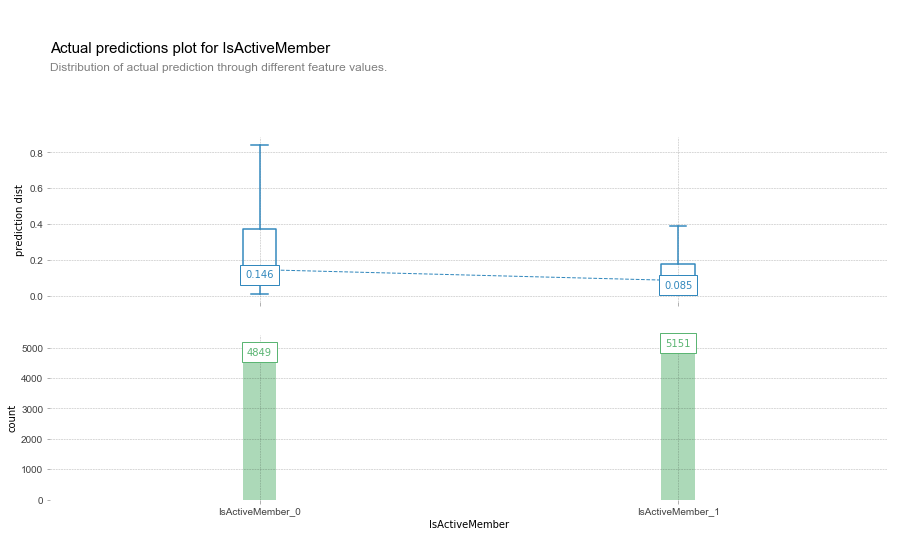

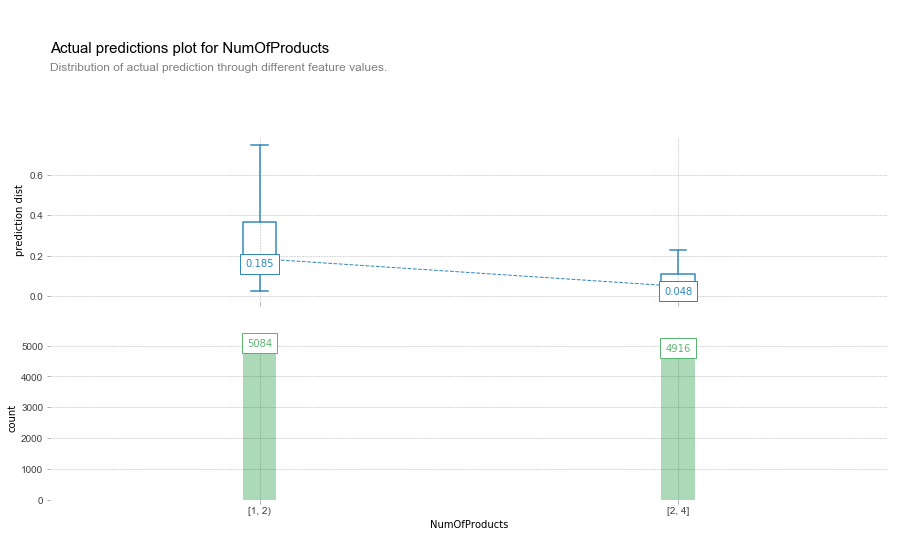

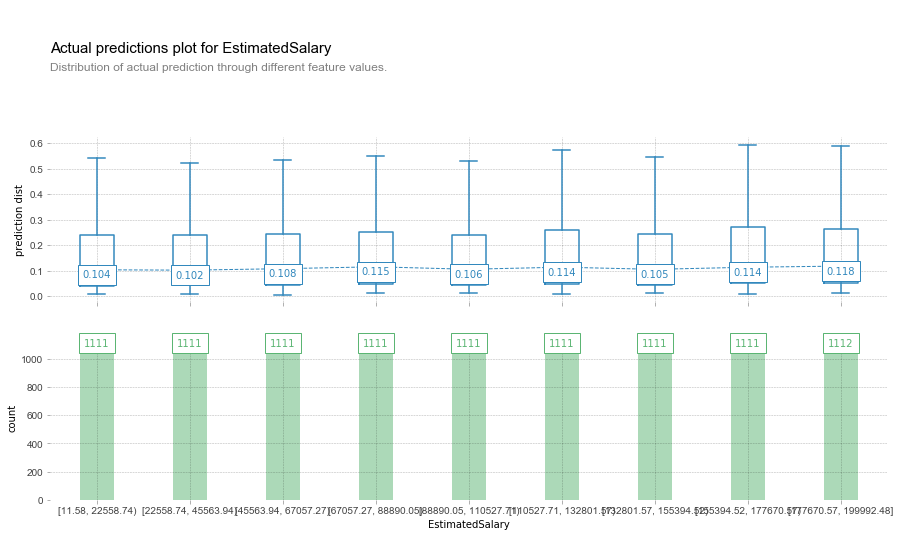

In [6]:
#Actual Plots
for _ in X.columns.tolist():
    fig,axes,summary_df=info_plots.actual_plot(
    model=baseline,
    X=df[X.columns],
    feature=_,
    feature_name=_,
    predict_kwds={}
    )

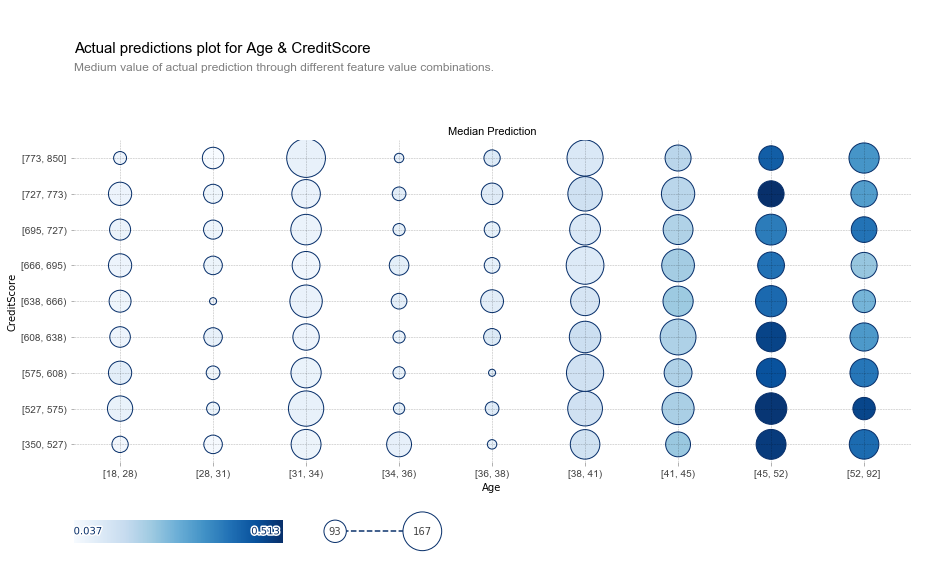

In [7]:
#Interaction plots
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=baseline, X=df[X.columns], features=interactions_2way, feature_names=interactions_2way
)


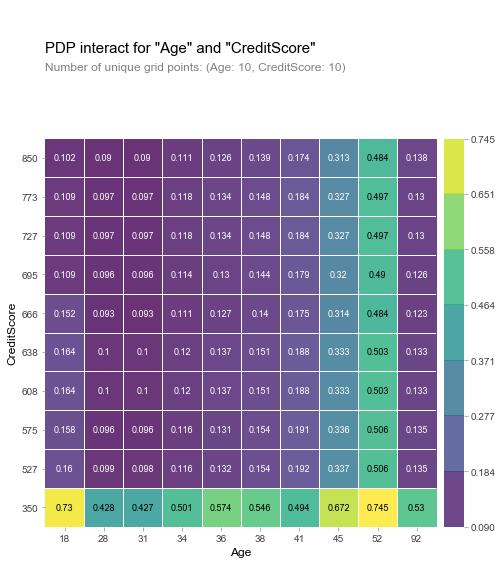

In [8]:
#Interaction tile
interactions = pdp.pdp_interact(
    model=baseline, dataset=df, model_features=X.columns, features=interactions_2way
)

fig, axes = pdp.pdp_interact_plot(interactions, interactions_2way, plot_type='grid', x_quantile=True, plot_pdp=False)

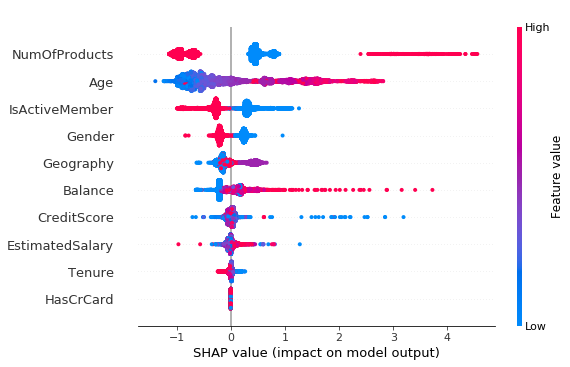

In [9]:
shap.initjs()
explainer=shap.TreeExplainer(baseline)
shap_values=explainer.shap_values(x_train[_feat])
shap.summary_plot(shap_values,x_train[_feat])

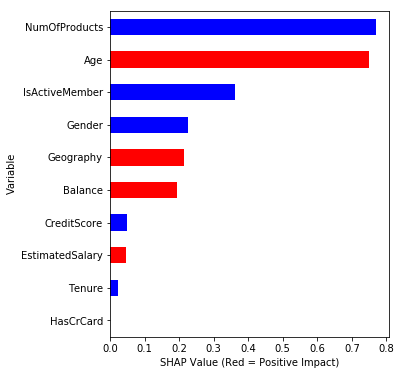

In [10]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)

    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')

    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
 
ABS_SHAP(shap_values,x_train)